In [82]:
import numpy as np
import pandas as pd
import dash
from dash import dcc
import dash_daq as daq
from dash import html
from dash import dash_table
from dash.dependencies import Input, Output
import psycopg2
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import os
import plotly.figure_factory as ff
import plotly.express as px
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')
import dash_bootstrap_components as dbc
import plotly.offline as py

In [2]:
engine = create_engine('postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}'.format(
    user = 'postgres',
    password = POSTGRES_PASSWORD,
    host = 'postgres',
    port = 5432,
    db = 'neurodash'
))

In [3]:
external_stylesheets = [dbc.themes.BOOTSTRAP]

In [4]:
mymarkdown = '''
NeuroDash is a dashboard to view the current neuroscience literature. The data for this dashobard come from [NeuroMorpho](https://neuromorpho.org/), [NeuroElectro](https://neuroelectro.org/), and [ModelDB](https://modeldb.science/). NeuroMorpho provides morphological data for neurons researchers find. NeuroElectro provides information about the electrophysiological properties of neurons found in the literature. Lastly, ModelDB provides information about computation neual models that researchers have created. These resources combine to illustrate research trends and findings in Neuroscience. They can serve as a jumping off point for someone looking to do their own research.
'''

In [5]:
myquery = '''
SELECT primary_brain_region, 
    COUNT(*) AS n_neurons
FROM neuron
WHERE primary_brain_region IS NOT NULL
GROUP BY primary_brain_region
ORDER BY n_neurons
    DESC
'''
data = pd.read_sql_query(myquery, con = engine)
primary_brain_regions = [x for x in data['primary_brain_region']]

In [6]:
measurements = ['soma_surface', 'n_stems', 'n_bifs', 'n_branch', 'width', 'height', 'depth', 'diameter', 'length']

In [7]:
myquery = '''
SELECT brainregion
FROM electro
WHERE brainregion IS NOT NULL
GROUP BY brainregion
'''
electro_regions = pd.read_sql_query(myquery, con = engine)

### Exploring how the neuron, electro, models data can combine on 
* brain_region
* pmid
* doi
* celltype ?

In [8]:
# there are some combos for the brain reigon in neuron to electro (cerebellum, hypothalamus, medulla, thalamus)
myquery = '''
SELECT n.primary_brain_region,
    e.brainregion
FROM neuron n
INNER JOIN electro e
    ON n.primary_brain_region = e.brainregion
GROUP BY n.primary_brain_region, 
    e.brainregion
'''
n_e_region = pd.read_sql_query(myquery, con = engine)

In [9]:
n_e_shared_regions = n_e_region['primary_brain_region'].unique()

In [10]:
# n_e_region
myquery = '''
SELECT n.neuron_id,
    e.electro_id
FROM neuron n
INNER JOIN electro e
    ON n.primary_brain_region = e.brainregion
GROUP BY n.neuron_id,
    e.electro_id
'''
n_e_link_region = pd.read_sql_query(myquery, con = engine)

In [11]:
# 10724 neurons to electro based on region
len(n_e_link_region['neuron_id'].unique())

10724

In [12]:
# neuron to electo pmid mapping
myquery = '''
SELECT j.neuron_id,
    e.electro_id
FROM electro e
INNER JOIN (SELECT *
FROM neuron_pmid n
INNER JOIN electro_pub e
    ON n.reference_pmid = CAST(e.pmid AS VARCHAR)) j
    ON CAST(e.pmid AS VARCHAR) = CAST(j.pmid AS VARCHAR)
GROUP BY j.neuron_id,
    e.electro_id
'''
n_e_pmid = pd.read_sql_query(myquery, con = engine)

In [13]:
len(n_e_pmid['neuron_id'].unique())

939

In [14]:
myquery = '''
SELECT j.model_id, 
    mr.primary_brain_region
FROM (SELECT m.model_id, 
            mtr.model_region_id
        FROM models m
        INNER JOIN model_to_region mtr
            ON m.model_id = mtr.model_id) j
INNER JOIN model_regions mr
    ON j.model_region_id = mr.model_region_id
'''
model_regions = pd.read_sql_query(myquery, con = engine)

In [15]:
myquery = '''
SELECT brainregion
FROM electro
WHERE brainregion IS NOT NULL
GROUP BY brainregion
'''
electro_regions = pd.read_sql_query(myquery, con = engine)

In [16]:
myquery = '''
SELECT n.neuron_id,
    n.primary_brain_region
FROM neuron n
'''
neuron = pd.read_sql_query(myquery, con = engine)

In [17]:
n_m_shared_regions = [x for x in neuron['primary_brain_region'].unique() if x in model_regions['primary_brain_region'].unique()]

In [18]:
model_regions = model_regions['primary_brain_region'].unique().tolist()

In [19]:
e_m_shared_regions = [x for x in electro_regions['brainregion'] if x in model_regions]
e_m_shared_regions

['thalamus', 'striatum', 'cerebellum']

In [20]:
three_shared_regions = [x for x in n_e_shared_regions if x in n_m_shared_regions]

myquery = '''
SELECT n.neuron_id,
    k.model_id,
    n.primary_brain_region,
    k.primary_brain_region
FROM neuron n
INNER JOIN (SELECT j.model_id, 
            mr.primary_brain_region
        FROM (SELECT m.model_id, 
                    mtr.model_region_id
                FROM models m
                INNER JOIN model_to_region mtr
                    ON m.model_id = mtr.model_id) j
        INNER JOIN model_regions mr
            ON j.model_region_id = mr.model_region_id) k
    ON n.primary_brain_region = k.primary_brain_region
'''
pd.read_sql_query(myquery, con = engine)

In [21]:
three_shared_regions

['cerebellum', 'thalamus']

In [22]:
electro_properties = ['jxnpotential', 'rin', 'rmp', 'apthr', 'aphw', 'tau', 'cap', 'apwidth', 'apfreq', 'rheo', 'sagratio', 'maxfreq', 'appeak', 'apdelay']
electro_summaries = ['brainregion', 'species', 'strain', 'electrodetype', 'preptype']
modeldb_categories = ['primary_brain_region', 'species', 'transmitter', 'concept', 'types', 'currents', 'celltypes']

In [23]:
def ModelDBtoTable(value):
    '''
    dictionary to map from modeldb category to tables and value
    List is: to_table, end_table, value_id, value_name
    '''
    mapping = {'primary_brain_region': ['model_to_region', 'model_regions', 'model_region_id', 'primary_brain_region'],
     'species': ['model_to_species', 'model_species', 'model_species_id', 'model_species_name'],
     'transmitter': ['model_to_transmitter', 'model_transmitters', 'model_transmitter_id', 'name'],
     'concept': ['model_to_concept', 'model_concepts', 'model_concept_id', 'name'],
     'types': ['model_to_types', 'model_types', 'model_type_id', 'name'],
     'currents': ['model_to_current', 'model_currents', 'model_current_id', 'model_current_name'],
     'celltypes': ['model_to_celltypes', 'model_celltypes', 'model_celltypes_id', 'name']
     }
    return mapping[value]

In [86]:
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(
    [
        html.H1("NeuroDash"),
        html.H2("Data collected from NeuroMorpho, NeuroElectro, & ModelDB"),
        html.H3("DS 6600: Data Engineering 1, UVA Data Science"),
        html.Div([
            dcc.Markdown('''**Pick the sources you want to be able to see all data from**'''),
            dcc.Checklist(options=[
                               {'label': 'NeuroMorpho', 'value': 'NeuroMorpho'},
                               {'label': 'NeuroElectro', 'value': 'NeuroElectro'},
                               {'label': 'ModelDB', 'value': 'ModelDB'},
                           ],
                           value=['NeuroMorpho'], id = 'source_checklist'),
            dcc.Markdown('''**Pick a Primary Brain Region to Study**'''),
            dcc.Dropdown(id = 'primary_brain_region', value = 'thalamus'),
            dcc.Markdown(mymarkdown)
        ], style = {'width': '24%', 'float': 'left'}),
        html.Div([
            dcc.Tabs([
                dcc.Tab(label = 'NeuroMorpho', children = [
                    # stuff for NeuroMorpho Goes Here
                    dcc.Tabs([
                        dcc.Tab(label = 'Average Measurements for Brain Region', children = [
                            html.Div([dcc.Graph(id = 'NeuronRegionTable')]),
                            dcc.Markdown('''**Select a Measure to Graph:**'''),
                            dcc.Dropdown(id = 'measurement', options = measurements, value = 'soma_surface'),
                            daq.BooleanSwitch(id = 'log', label = 'Logarithmic Measurement', on = False),
                            dcc.Graph(id = 'NeuronMeasurementGraph')
                            ]),
                        dcc.Tab(label = 'Example Images for Brain Region', children = [
                            # put stuff for NeuroMorpho Images
                            dcc.Markdown('''Below is an example neuron and some basic information about it it:'''),
                            html.Button(id = 'neuron_image_button', children = 'Click to See a New Neuron', style = {'background-color': '#092670', 'color': 'white'}),
                            dcc.Markdown('''Publication DOI:'''),
                            dcc.Markdown(id = 'neuron_doi'),
                            html.Div([dcc.Graph(id = 'NeuroMorphPicTable')]),
                            html.Div([html.Img(id = 'NeuroMorphPic', style={'height':'100%', 'width':'100%'})])      
                        ])
                    ])
                ]),
                dcc.Tab(label = 'NeuroElectro', children = [
                    # stuff for NeuroElectro goes Here
                    dcc.Tabs([
                        dcc.Tab(label = 'Brain Region Measurements', children = [
                            dcc.Markdown('''**Select from below the electrophysiological properties you want to explore:**'''),
                            dcc.Markdown('''*Disclaimer: If no graph appears, it is likely that there is no data for this brain region or variable. You can help find these values in the current literature or through your own research!*'''),
                            dcc.Dropdown(id = 'ElectroDropDown', options = electro_properties, value = 'rmp'),
                            dcc.Graph(id = 'ElectroGraph')
                        ]),
                        dcc.Tab(label = 'Summary Data', children = [
                            dcc.Markdown('''Below is summary data on what observations can be found from NeuroElectro:'''),
                            dcc.Markdown('''**Please select a summary measure to view:**'''),
                            dcc.Dropdown(id = 'ElectroSummaryDropdown', options = electro_summaries, value = 'brainregion'),
                            dcc.Graph(id = 'ElectroSummaryGraph')
                        ])
                                
                    ])
                ]),
                dcc.Tab(label = 'ModelDB', children = [
                    # stuff for ModelDB goes here
                    dcc.Tabs([
                        dcc.Tab(label = 'Models in Selected Brain Region', children = [
                            dcc.Graph(id = 'PubsGraph'),
                            dcc.Graph(id = 'ModelRegionTable')
                        ]),
                        dcc.Tab(label = 'Model Counts per Category', children = [
                            dcc.Markdown('''Below is information about the number of models found on ModelDB based on specific categories'''),
                            dcc.Markdown('''**Please select a category to view:**'''),
                            dcc.Dropdown(id = 'ModelDBCategoryDropdown', options = modeldb_categories, value = 'primary_brain_region'),
                            dcc.Graph(id = 'ModelDBCategoryGraph')
                        ]),
                    ])
                ])
            ])
        ], style = {'width': '74%', 'float': 'right'})
    ]
)

@app.callback([Output(component_id = 'NeuronRegionTable', component_property = 'figure')],
              [Input(component_id = 'primary_brain_region', component_property = 'value')])

def NeuronRegionTable(primary_brain_region):
    myquery = f'''
    SELECT ROUND(AVG(soma_surface)) AS soma_surface,
        ROUND(AVG(n_stems)) AS number_stems,
        ROUND(AVG(n_bifs)) AS number_biffurcations,
        ROUND(AVG(n_branch)) AS number_branches,
        ROUND(AVG(width)) AS width,
        ROUND(AVG(height)) AS height,
        ROUND(AVG(depth)) AS depth,
        ROUND(AVG(diameter)) AS diameter,
        ROUND(AVG(length)) AS length
    FROM neuron
    WHERE primary_brain_region = '{primary_brain_region}'
    '''
    data = pd.read_sql_query(myquery, con = engine)
    data['primary_brain_region'] = pd.Series([primary_brain_region])

    data.rename(columns = {'primary_brain_region': 'Region',
                'soma_surface': 'Soma Surface',
                'number_stems': 'Num Stems',
                'number_biffurcations': 'Num Biffurcations',
                'number_branches': 'Num Branches',
                'width': 'Width',
                'height': 'Height',
                'depth': 'Depth',
                'diameter': 'Diameter',
                'length': 'Length'}, inplace = True)
    
    table = ff.create_table(data[['Region', 'Soma Surface', 'Num Stems', 'Num Biffurcations',
       'Num Branches', 'Width', 'Height', 'Depth', 'Diameter', 'Length']])
    return [table]

@app.callback([Output(component_id = 'primary_brain_region', component_property = 'options')],
             [Input(component_id = 'source_checklist', component_property = 'value')])
def SelectDataSources(s):
    if ('NeuroMorpho' in s) & ('NeuroElectro' in s) & ('ModelDB' in s):
        options = three_shared_regions
    elif ('NeuroMorpho' in s) & ('NeuroElectro' in s) & ('ModelDB' not in s):
        options = n_e_shared_regions
    elif ('NeuroMorpho' in s) & ('NeuroElectro' not in s) & ('ModelDB' in s):
        options = n_m_shared_regions
    elif ('NeuroMorpho' not in s) & ('NeuroElectro' not in s) & ('ModelDB' in s):
        options = model_regions
    elif ('NeuroMorpho' not in s) & ('NeuroElectro' in s) & ('ModelDB' not in s): 
        options = electro_regions['brainregion'].unique().tolist()
    elif ('NeuroMorpho' not in s) & ('NeuroElectro' in s) & ('ModelDB' in s):
        options = e_m_shared_regions
    else:
        options = primary_brain_regions
    return [options]

@app.callback([Output(component_id = 'NeuronMeasurementGraph', component_property = 'figure')],
              [Input(component_id = 'primary_brain_region', component_property = 'value'),
               Input(component_id = 'measurement', component_property = 'value'),
               Input(component_id = 'log', component_property = 'on')])

def NeuronMeasurement(primary_brain_region, measurement, log):
    myquery = f'''
    SELECT {measurement}
    FROM neuron
    WHERE primary_brain_region = '{primary_brain_region}'
    '''
    data = pd.read_sql_query(myquery, con = engine)
    title = 'Box plot for Neuron ' + measurement + ' in the ' + primary_brain_region
    if log:
        xaxis = 'Log Measurement of ' + measurement
    else:
        xaxis = measurement
    fig = px.box(x = data[measurement], log_x = log, title = title)
    fig.update_layout(xaxis_title = xaxis,
                     title_x = 0.5)

    return [fig]

@app.callback([Output(component_id = 'NeuroMorphPic', component_property = 'src'),
               Output(component_id = 'NeuroMorphPicTable', component_property = 'figure'),
              Output(component_id = 'neuron_doi', component_property = 'children')],
              [Input(component_id = 'primary_brain_region', component_property = 'value'),
              Input(component_id = 'neuron_image_button', component_property = 'n_clicks')])

def NeuroMorphoImage(primary_brain_region, n_clicks):
    primary_brain_region = 'neocortex'
    myquery = f'''
    SELECT n.neuron_id,
        n.neuron_name AS Name, 
        n.primary_brain_region AS Region, 
        n.png_url,
        nd.reference_doi AS DOI,
        n.species,
        n.strain
    FROM neuron n
    INNER JOIN neuron_doi nd
        ON n.neuron_id = nd.neuron_id
    WHERE primary_brain_region = '{primary_brain_region}' AND png_url IS NOT NULL
    '''
    data = pd.read_sql_query(myquery, con = engine)
    data.rename(columns = {'name': 'Name',
                          'region': 'Region',
                          'doi': 'DOI',
                          'species': 'Species',
                          'strain': 'Strain'}, inplace = True)
    
    sampled_row = data.sample()
    
    sampled_row['DOI'] = 'https://doi.org/' + sampled_row['DOI'].iloc[0]
    doi = sampled_row['DOI'].iloc[0]
    url = sampled_row['png_url'].iloc[0]
    fig = ff.create_table(sampled_row[['Name', 'Region', 'Species', 'Strain']])

    return [url, fig, doi]

@app.callback([Output(component_id = 'ElectroGraph', component_property = 'figure')],
              [Input(component_id = 'primary_brain_region', component_property = 'value'),
               Input(component_id = 'ElectroDropDown', component_property = 'value')])

def ElectroMeasurements(primary_brain_region, value):
    try:
        myquery = f'''
        SELECT {value}
        FROM electro
        WHERE brainregion = '{primary_brain_region}' AND {value} IS NOT NULL
        '''
        data = pd.read_sql_query(myquery, con = engine)
        num_observation = len(data)
        xaxis = value
        fig = px.box(x = data[value], title = value + ' for Neurons found in the ' + primary_brain_region + ' (n = ' + str(num_observation) + ')')
        fig.update_layout(xaxis_title = xaxis,
                         title_x = 0.5)
        return [fig]
    except:
        return [None]

@app.callback([Output(component_id = 'ElectroSummaryGraph', component_property = 'figure')],
             [Input(component_id = 'ElectroSummaryDropdown', component_property = 'value')])

def ElectroSummaryGraph(value):
    myquery = f'''
    SELECT {value},
        COUNT({value}) AS num_observations
    FROM electro
    GROUP BY {value}
    HAVING {value} IS NOT NULL
    ORDER BY num_observations
    DESC
    '''
    data = pd.read_sql_query(myquery, con = engine)
    fig = px.bar(y = data[value], x = data['num_observations'], title = 'Number of Observations for ' + value + ' in NeuroElectro')
    fig.update_layout(xaxis_title = 'Number of Observations',
                     yaxis_title = value,
                     title_x = 0.5)
    return [fig]

@app.callback([Output(component_id = 'ModelDBCategoryGraph', component_property = 'figure')],
             [Input(component_id = 'ModelDBCategoryDropdown', component_property = 'value')])

def ModelDBCategoryGraphs(value):
    mapping = ModelDBtoTable(value)
    myquery = f'''
    SELECT e.{mapping[3]},
        COUNT(e.{mapping[3]}) AS num_models
    FROM (SELECT m.model_id,
                t.{mapping[2]}
        FROM models m
        INNER JOIN {mapping[0]} t
            ON m.model_id = t.model_id) j
    INNER JOIN {mapping[1]} e
        ON j.{mapping[2]} = e.{mapping[2]}
    GROUP BY e.{mapping[3]}
    ORDER BY num_models
        DESC
    '''
    data = pd.read_sql_query(myquery, con = engine)
    fig = px.bar(x = data['num_models'], y = data[mapping[3]], title = 'Number of Models by ' + value)
    fig.update_layout(xaxis_title = 'Number of Models', yaxis_title = value, title_x = 0.5)

    return [fig]

@app.callback([Output(component_id = 'PubsGraph', component_property = 'figure')],
             [Input(component_id = 'primary_brain_region', component_property = 'value')])

def ModelDBPubsGraph(primary_brain_region):
    myquery = f'''
    SELECT mr.primary_brain_region, 
        j.model_id
    FROM (SELECT m.model_id,
                mtr.model_region_id
        FROM models m
        INNER JOIN model_to_region mtr
            ON m.model_id = mtr.model_id) j
    INNER JOIN model_regions mr
        ON j.model_region_id = mr.model_region_id
    WHERE primary_brain_region = '{primary_brain_region}'
    '''
    data = pd.read_sql_query(myquery, con = engine)

    model_ids = tuple(data['model_id'].tolist())

    myquery = f'''
    SELECT *
    FROM (SELECT m.model_id,
            mtp.model_paper_id
        FROM models m
        INNER JOIN model_to_papers mtp
            ON m.model_id = mtp.model_id) j
    INNER JOIN model_papers mp
        ON j.model_paper_id = mp.model_paper_id
    WHERE j.model_id IN {model_ids} AND mp.year IS NOT NULL
    '''
    data = pd.read_sql_query(myquery, con = engine)

    limit = pd.Series(data['year'].value_counts()).iloc[0]

    fig = px.line(x = data['year'].unique(), y = data['year'].value_counts(), 
                  title = 'Publications by Year for Models in ' + primary_brain_region + ' (n = ' + str(len(data)) + ')')
    fig.update_layout(xaxis_title = 'Year', yaxis_title = 'Number of Models', title_x = 0.5, yaxis_range = [0,limit + 1])
    fig.update_xaxes(tickangle=45)
    
    return [fig]

@app.callback([Output(component_id = 'ModelRegionTable', component_property = 'figure')],
             [Input(component_id = 'primary_brain_region', component_property = 'value')])

def ModelRegionTable(primary_brain_region):
    myquery = f'''
    SELECT j.model_id,
        j.name AS model_name
    FROM (SELECT m.model_id,
                m.name,
                mtr.model_region_id
        FROM models m
        INNER JOIN model_to_region mtr
            ON m.model_id = mtr.model_id) j
    INNER JOIN model_regions mr
        ON j.model_region_id = mr.model_region_id
    WHERE primary_brain_region = '{primary_brain_region}'
    '''
    data = pd.read_sql_query(myquery, con = engine)

    model_ids = tuple(data['model_id'].tolist())
    
    myquery = f'''
    SELECT *
    FROM (SELECT j.model_id,
                j.name AS model_name
            FROM (SELECT m.model_id,
                        m.name,
                        mtr.model_region_id
                FROM models m
                INNER JOIN model_to_region mtr
                    ON m.model_id = mtr.model_id) j
            INNER JOIN model_regions mr
                ON j.model_region_id = mr.model_region_id
            WHERE primary_brain_region = '{primary_brain_region}') l
    INNER JOIN (SELECT *
                FROM (SELECT m.model_id,
                        mtp.model_paper_id
                    FROM models m
                    INNER JOIN model_to_papers mtp
                        ON m.model_id = mtp.model_id) j
                INNER JOIN model_papers mp
                    ON j.model_paper_id = mp.model_paper_id
                WHERE j.model_id IN {model_ids}) r
        ON l.model_id = r.model_id
    '''
    data = pd.read_sql_query(myquery, con = engine)
    
    table = data[['model_name', 'name', 'title', 'pubmed']]
    table.rename(columns = {'model_name': 'Model',
                           'name': 'Authors',
                           'title': 'Paper Title',
                           'pubmed': 'PMID'}, inplace=True)
    fig = ff.create_table(table)
    fig.layout.width=1000
    return [fig]
    
# Execution
if __name__ == "__main__":
    app.run_server(mode='external', host = '0.0.0.0', port = 8050, debug = True)

In [25]:
primary_brain_region = 'neocortex'
myquery = f'''
SELECT *
FROM neuron
WHERE primary_brain_region = '{primary_brain_region}'
'''
data = pd.read_sql_query(myquery, con = engine)

In [26]:
test = ['NeuroMorpho', 'NeuroElectro', 'ModelDB']
if ('ModelDB' in test) & ('NeuroElectro' in test):
    print('yes')

yes


In [27]:
neuron_columns = [x for x in data.columns]

In [28]:
data.columns

Index(['neuron_id', 'neuron_name', 'archive', 'note', 'age_scale', 'gender',
       'age_classification', 'species', 'strain', 'scientific_name', 'stain',
       'protocol', 'slicing_direction', 'reconstruction_software',
       'objective_type', 'original_format', 'magnification', 'upload_date',
       'deposition_date', 'shrinkage_reported', 'shrinkage_corrected',
       'reported_value', 'reported_xy', 'reported_z', 'corrected_value',
       'corrected_xy', 'corrected_z', 'surface_x', 'volume_x',
       'slicing_thickness', 'min_age', 'max_age', 'min_weight', 'max_weight',
       'png_url', 'physical_integrity', '_links.self.href',
       '_links.measurements.href', '_links.persistence_vector.href',
       'brain_region_len', 'primary_brain_region', 'secondary_brain_region',
       'tertiary_brain_region', 'dendrites', 'soma', 'axon', 'processes',
       'neurites', 'att_diameter', 'att_angles', 'att_3d', 'surface_y',
       'volume_y', 'soma_surface', 'n_stems', 'n_bifs', 'n_branch

In [29]:
# gender, age_classification, species, png_url, primary_brain_region, dendrites, soma, axon, processes, neurites, soma_surface, n_stems, n_biffs, n_branch, width, height, depth, diameter, length
primary_brain_region = 'neocortex'
myquery = f'''
SELECT ROUND(AVG(soma_surface)) AS soma_surface,
    ROUND(AVG(n_stems)) AS number_stems,
    ROUND(AVG(n_bifs)) AS number_biffurcations,
    ROUND(AVG(n_branch)) AS number_branches,
    ROUND(AVG(width)) AS width,
    ROUND(AVG(height)) AS height,
    ROUND(AVG(depth)) AS depth,
    ROUND(AVG(diameter)) AS diameter,
    ROUND(AVG(length)) AS length
FROM neuron
WHERE primary_brain_region = '{primary_brain_region}'
'''
data = pd.read_sql_query(myquery, con = engine)
data['primary_brain_region'] = pd.Series([primary_brain_region])

table = ff.create_table(data[['primary_brain_region', 'soma_surface', 'number_stems', 'number_biffurcations',
   'number_branches', 'width', 'height', 'depth', 'diameter', 'length']])

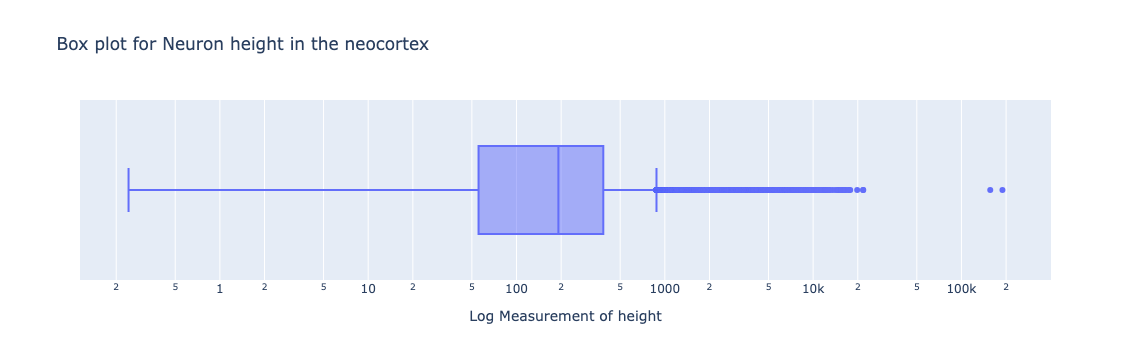

In [30]:
primary_brain_region = 'neocortex'
measurement = 'height'
log = True
myquery = f'''
SELECT {measurement}
FROM neuron
WHERE primary_brain_region = '{primary_brain_region}'
'''
data = pd.read_sql_query(myquery, con = engine)
title = 'Box plot for Neuron ' + measurement + ' in the ' + primary_brain_region
if log:
    xaxis = 'Log Measurement of ' + measurement
else:
    xaxis = measurement
fig = px.box(x = data[measurement], log_x = log, title = title)
fig.update_layout(xaxis_title = xaxis)

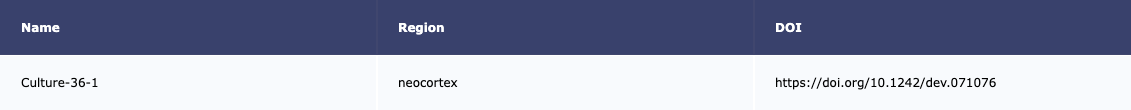

In [31]:
primary_brain_region = 'neocortex'
myquery = f'''
SELECT n.neuron_id,
    n.neuron_name AS Name, 
    n.primary_brain_region AS Region, 
    n.png_url,
    nd.reference_doi AS DOI
FROM neuron n
INNER JOIN neuron_doi nd
    ON n.neuron_id = nd.neuron_id
WHERE primary_brain_region = '{primary_brain_region}' AND png_url IS NOT NULL
'''
data = pd.read_sql_query(myquery, con = engine)
data.rename(columns = {'name': 'Name',
                      'region': 'Region',
                      'doi': 'DOI'}, inplace = True)

sampled_row = data.sample()

sampled_row['DOI'] = 'https://doi.org/' + sampled_row['DOI'].iloc[0]
url = sampled_row['png_url']
ff.create_table(sampled_row[['Name', 'Region', 'DOI']])

In [32]:
sampled_row['DOI'].iloc[0]

'https://doi.org/10.1242/dev.071076'

In [33]:
data

neuron_id                          Name     Region  \
0              1                      cnic_001  neocortex   
1              1                      cnic_001  neocortex   
2             10                      cnic_041  neocortex   
3             10                      cnic_041  neocortex   
4           1000                    DS3_030701  neocortex   
...          ...                           ...        ...   
55697      99961   Blue12_9-17-12_sec2_Neuron7  neocortex   
55698      99962   Blue9_9-17-12_sec3_Neuron10  neocortex   
55699      99963    Blue9_9-17-12_sec3_Neuron9  neocortex   
55700      99964  Orange5_3-22-13_sec1_Neuron1  neocortex   
55701      99965  Orange5_3-22-13_sec3_Neuron3  neocortex   

                                                 png_url  \
0      http://neuromorpho.org/images/imageFiles/Wearn...   
1      http://neuromorpho.org/images/imageFiles/Wearn...   
2      http://neuromorpho.org/images/imageFiles/Wearn...   
3      http://neuromorpho.org/images/imageFiles/Wearn...   
4      http://neuromorpho.org/images/imageFiles/Staig...   
...                                                  ...   
55697  http://neuromorpho.org/images/imageFiles/Hrvoj...   
55698  http://neuromorpho.org/images/imageFiles/Hrvoj...   
55699  http://neuromorpho.org/images/imageFiles/Hrvoj...   
55700  http://neuromorpho.org/images/imageFiles/Hrvoj...   
55701  http://neuromorpho.org/images/imageFiles/Hrvoj...   

                                 DOI  
0      10.1016/S0306-4522(02)00305-6  
1            10.1093/cercor/13.9.950  
2            10.1093/cercor/13.9.950  
3      10.1016/S0306-4522(02)00305-6  
4              10.1093/cercor/bhh029  
...                              ...  
55697       10.3389/fnins.2017.00419  
55698       10.3389/fnins.2017.00419  
55699       10.3389/fnins.2017.00419  
55700       10.3389/fnins.2017.00419  
55701       10.3389/fnins.2017.00419  

[55702 rows x 5 columns]

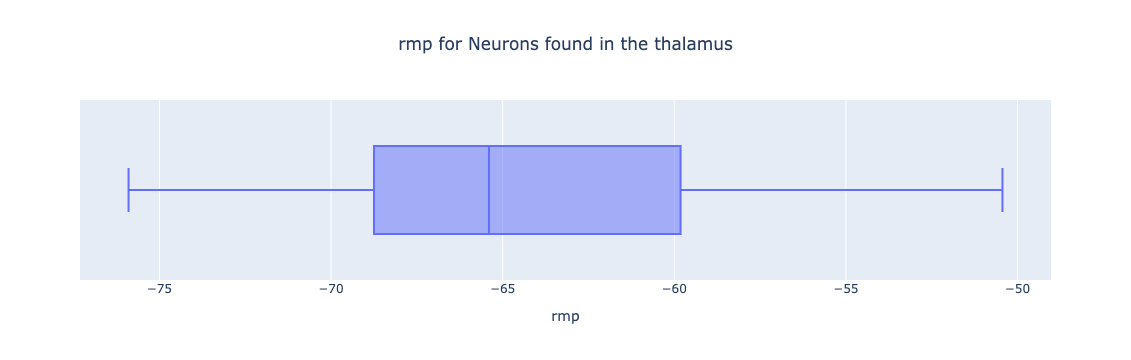

In [34]:
value = 'rmp'
primary_brain_region = 'thalamus'
myquery = f'''
SELECT {value}
FROM electro
WHERE brainregion = '{primary_brain_region}' AND {value} IS NOT NULL
'''
data = pd.read_sql_query(myquery, con = engine)
xaxis = value
fig = px.box(x = data[value], title = value + ' for Neurons found in the ' + primary_brain_region)
fig.update_layout(xaxis_title = xaxis,
                 title_x = 0.5)

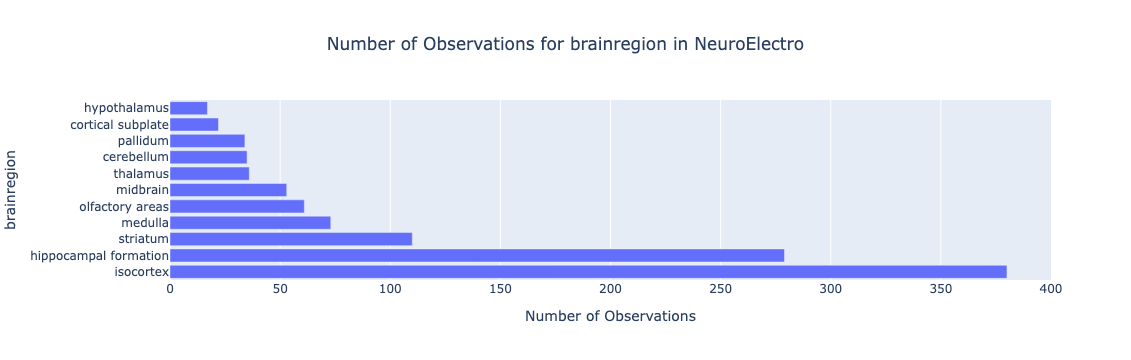

In [35]:
value = 'brainregion'
myquery = f'''
SELECT {value},
    COUNT({value}) AS num_observations
FROM electro
GROUP BY {value}
HAVING {value} IS NOT NULL
ORDER BY num_observations
DESC
'''
data = pd.read_sql_query(myquery, con = engine)
fig = px.bar(y = data[value], x = data['num_observations'], title = 'Number of Observations for ' + value + ' in NeuroElectro')
fig.update_layout(xaxis_title = 'Number of Observations',
                 yaxis_title = value,
                 title_x = 0.5)

In [36]:
# modeldb papers
myquery = '''
SELECT *
FROM (SELECT *
    FROM models m
    INNER JOIN model_to_papers mtp
        ON m.model_id = mtp.model_id) j
INNER JOIN model_papers mp
    ON j.model_paper_id = mp.model_paper_id

'''
#pd.read_sql_query(myquery, con = engine)

In [37]:
# model db id to region
myquery = '''
SELECT j.model_id, 
    mr.model_region_id,
    mr.primary_brain_region
FROM (SELECT m.model_id,
            mtr.model_region_id
    FROM models m
    INNER JOIN model_to_region mtr
        ON m.model_id = mtr.model_id) j
INNER JOIN model_regions mr
    ON j.model_region_id = mr.model_region_id
'''
pd.read_sql_query(myquery, con = engine)

model_id  model_region_id primary_brain_region
0        2730           115950       olfactory bulb
1        2798           115949     olfactory cortex
2        3264           266986        visual cortex
3        3343           115951             thalamus
4        3434           143145   auditory brainstem
..        ...              ...                  ...
928    267618           228598                mouse
929    267598           115946          hippocampus
930   2014996           183076            brainstem
931   2015413           206363           drosophila
932   2015412           206363           drosophila

[933 rows x 3 columns]

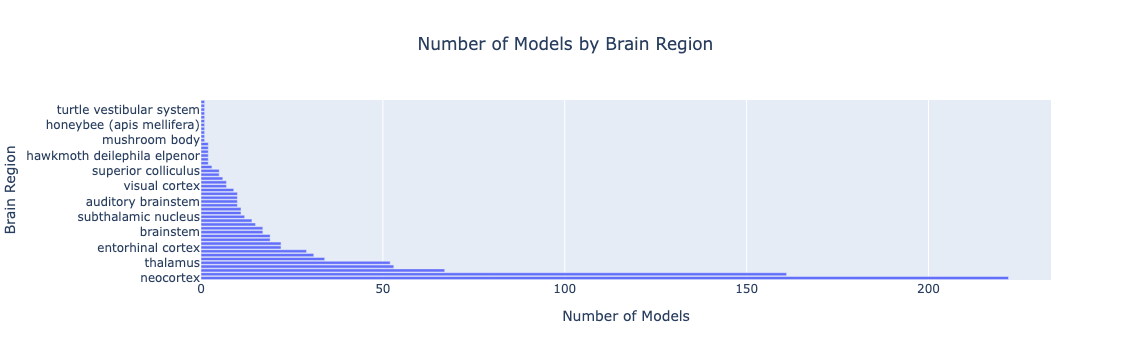

In [38]:
myquery = '''
SELECT mr.primary_brain_region,
    COUNT(mr.primary_brain_region) AS num_models
FROM (SELECT m.model_id,
            mtr.model_region_id
    FROM models m
    INNER JOIN model_to_region mtr
        ON m.model_id = mtr.model_id) j
INNER JOIN model_regions mr
    ON j.model_region_id = mr.model_region_id
GROUP BY mr.primary_brain_region
ORDER BY num_models
    DESC
'''
data = pd.read_sql_query(myquery, con = engine)
fig = px.bar(x = data['num_models'], y = data['primary_brain_region'], title = 'Number of Models by Brain Region')
fig.update_layout(xaxis_title = 'Number of Models', yaxis_title = 'Brain Region', title_x = 0.5)

In [61]:
primary_brain_region = 'thalamus'
myquery = f'''
SELECT j.model_id,
    j.name AS model_name
FROM (SELECT m.model_id,
            m.name,
            mtr.model_region_id
    FROM models m
    INNER JOIN model_to_region mtr
        ON m.model_id = mtr.model_id) j
INNER JOIN model_regions mr
    ON j.model_region_id = mr.model_region_id
WHERE primary_brain_region = '{primary_brain_region}'
'''
data = pd.read_sql_query(myquery, con = engine)


In [62]:
data

model_id                                         model_name
0       3343  Thalamocortical and Thalamic Reticular Network...
1       3670   Thalamic Reticular Network (Destexhe et al 1994)
2       9889  Thalamic quiescence of spike and wave seizures...
3      12631  Computer model of clonazepam's effect in thala...
4      28189  Sleep-wake transitions in corticothalamic syst...
5      37819  Thalamocortical augmenting response (Bazhenov ...
6      45539  A single column thalamocortical network model ...
7      58582  Coding of stimulus frequency by latency in tha...
8     111870  Thalamic transformation of pallidal input (Had...
9     116862  Thalamic interneuron multicompartment model (Z...
10    116867  High frequency stimulation of the Subthalamic ...
11    122369  Investigation of different targets in deep bra...
12    124111  A contracting model of the basal ganglia (Gira...
13    137676  Sensory feedback in an oscillatory interferenc...
14    138970  A Neural mass computational model of the Thala...
15    140964  Event-related simulation of neural processing ...
16    143635  Active dendritic action potential propagation ...
17    147366  Composite spiking network/neural field model o...
18    150240  A Model Circuit of Thalamocortical Convergence...
19    151951  Mechanisms for stable, robust, and adaptive de...
20    152113  Basal ganglia-corticothalamic (BGCT) network (...
21    152197  Simulated cortical color opponent receptive fi...
22    156039  The subcellular distribution of T-type Ca2+ ch...
23    195659  Multiple dynamical modes of thalamic relay neu...
24    206232  Cortex-Basal Ganglia-Thalamus network model (K...
25    223891  Rat LGN Thalamocortical Neuron (Connelly et al...
26    225583  Collection of simulated data from a thalamocor...
27    226473  Neural mass model of spindle generation in the...
28    226474  Neural mass model of the sleeping thalamocorti...
29    232876  Thalamocortical Relay cell under current clamp...
30    233509  A unified thalamic model of multiple distinct ...
31    234118  A spiking neural network model of the Lateral ...
32    234233  Knox implementation of Destexhe 1998 spike and...
33    235561  The origin of different spike and wave-like ev...
34    235768  Unbalanced peptidergic inhibition in superfici...
35    237348  Synaptic damage underlies EEG abnormalities in...
36    238920  LFP signature of monosynaptic thalamocortical ...
37    239878  Cortical feedback alters visual response prope...
38    244262  Deconstruction of cortical evoked potentials g...
39    247704  Thalamocortical  loop with delay for investiga...
40    251881  Thalamocortical relay neuron models constraine...
41    257028  A cortico-cerebello-thalamo-cortical loop mode...
42    258478  Dynamics of sleep oscillations coupled to brai...
43    260949  Mechanisms for pattern specificity of DBS in P...
44    260960  Thalamocortical control of propofol phase-ampl...
45    261882  Network model of movement disorders (Yousif et...
46    263703  Alpha rhythm in vitro visual cortex (Traub et ...
47    263705  Electrodecrements in in vitro model of infanti...
48    266552  Disrupted information processing in Fmr1-KO mo...
49    266941  Thalamo-cortical microcircuit (TCM) (AmirAli F...
50    266989  Ventromedial Thalamocortical Neuron (Bichler e...
51    267511  Biophysically detailed model of somatosensory ...

In [69]:
model_ids = tuple(data['model_id'].tolist())

myquery = f'''
SELECT *
FROM (SELECT j.model_id,
            j.name AS model_name
        FROM (SELECT m.model_id,
                    m.name,
                    mtr.model_region_id
            FROM models m
            INNER JOIN model_to_region mtr
                ON m.model_id = mtr.model_id) j
        INNER JOIN model_regions mr
            ON j.model_region_id = mr.model_region_id
        WHERE primary_brain_region = '{primary_brain_region}') l
INNER JOIN (SELECT *
            FROM (SELECT m.model_id,
                    mtp.model_paper_id
                FROM models m
                INNER JOIN model_to_papers mtp
                    ON m.model_id = mtp.model_id) j
            INNER JOIN model_papers mp
                ON j.model_paper_id = mp.model_paper_id
            WHERE j.model_id IN {model_ids}) r
    ON l.model_id = r.model_id
'''
data = pd.read_sql_query(myquery, con = engine)

table = data[['model_name', 'name', 'title', 'pubmed']]
table.rename(columns = {'model_name': 'Model',
                       'name': 'Authors',
                       'title': 'Paper Title',
                       'pubmed': 'PMID'}, inplace=True)
ff.create_table(table)

In [66]:
myquery = f'''
SELECT j.model
FROM (SELECT m.model_id,
        mtp.model_paper_id
    FROM models m
    INNER JOIN model_to_papers mtp
        ON m.model_id = mtp.model_id) j
INNER JOIN model_papers mp
    ON j.model_paper_id = mp.model_paper_id
WHERE j.model_id IN {model_ids}  
'''
data = pd.read_sql_query(myquery, con = engine)

0     232876
1     232876
2       3343
3       3670
4     232876
       ...  
62    263705
63    266552
64    266941
65    266989
66    267511
Name: model_id, Length: 67, dtype: int64

In [42]:
limit = pd.Series(data['year'].value_counts()).iloc[0]

In [43]:
data['year'] = data['year'].astype('int')
minimum = min(data['year'])
maximum = max(data['year'])
data['year'].value_counts()

year
2014    11
2017     7
2019     5
2018     5
2011     4
2013     4
2020     3
1998     3
2005     3
2001     3
1996     2
2006     2
2016     2
1997     2
2015     2
1994     2
2021     2
1999     1
2004     1
2009     1
2002     1
2022     1
Name: count, dtype: int64

In [50]:
y = [x for x in range(minimum, maximum + 1)]
y

[1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]

In [56]:
#fig = px.line(x = range(minimum, maximum + 1), y = data['year'].value_counts(), title = 'Publications by Year for Models in ' + primary_brain_region + ' (n = ' + str(len(data)) + ')')
#fig.update_layout(xaxis_title = 'Year', yaxis_title = 'Number of Models', title_x = 0.5, yaxis_range = [0,limit + 1], xaxis_range = [min, max])
#fig.update_xaxes(tickangle=45)